In [1]:
#Checking for tensorflow 2 and GPU
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
#Mounting my google drive
import os
from google.colab import drive
root = "/content/gdrive" 
drive.mount(root)
files_path = '/content/gdrive/My Drive/kaggle/' 
os.chdir(files_path)
!ls 

# Connect to Github

In [6]:
# Clone github repository setup
# import join used to join ROOT path and MY_GOOGLE_DRIVE_PATH
from os.path import join  

# path to your project on Google Drive
MY_GOOGLE_DRIVE_PATH = 'My Drive/Colab Notebooks/4 models' 
# replace with your Github username 
GIT_USERNAME = "psyryuvok" 
# definitely replace with your
GIT_TOKEN = "bce6ac9831ee2cdb67dca6960adcc39684e80a75"  
# Replace with your github repository in this case we want 
# to clone deep-learning-v2-pytorch repository
GIT_REPOSITORY = "Brain-Tumor-Search" 

PROJECT_PATH = join(root, MY_GOOGLE_DRIVE_PATH)

# It's good to print out the value if you are not sure 
print("PROJECT_PATH: ", PROJECT_PATH)   

# In case we haven't created the folder already; we will create a folder in the project path 
!mkdir "{PROJECT_PATH}"    

#GIT_PATH = "https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git" this return 400 Bad Request for me
GIT_PATH = "https://" + GIT_TOKEN + "@github.com/" + GIT_USERNAME + "/" + GIT_REPOSITORY + ".git"
print("GIT_PATH: ", GIT_PATH)

PROJECT_PATH:  /content/gdrive/My Drive/Colab Notebooks/4 models
mkdir: cannot create directory ‘/content/gdrive/My Drive/Colab Notebooks/4 models’: File exists
GIT_PATH:  https://bce6ac9831ee2cdb67dca6960adcc39684e80a75@github.com/psyryuvok/Brain-Tumor-Search.git


In [12]:
os.chdir(join(PROJECT_PATH,GIT_REPOSITORY))

In [13]:
!ls

LICENSE  README.md  tem2.0.ipynb


In [15]:
!git add .
!git commit -m "Adding notebook"
!git push origin main


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@0f3a6a58a36e.(none)')
Everything up-to-date


# Model training

Model: "neurak"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0    

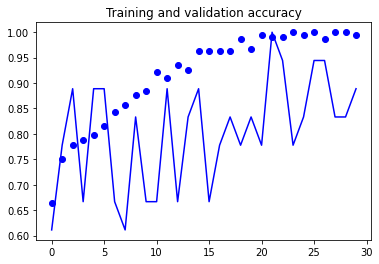

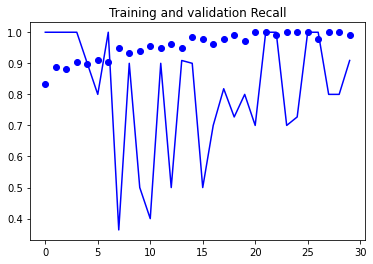

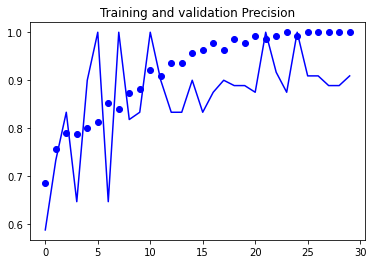

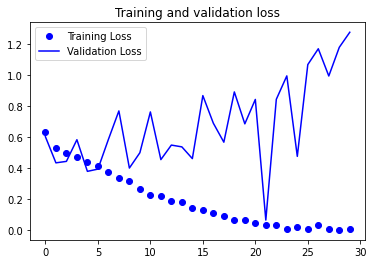

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!pip install rarfile
import rarfile
r = rarfile.RarFile('brain_tumor_datasets.rar')
r.extractall('/tmp')
r.close()


base_dir = '/tmp/brain_tumor_dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training tumor pictures
train_yes_dir = os.path.join(train_dir, 'yes')

# Directory with our training healthy pictures
train_no_dir = os.path.join(train_dir, 'no')

# Directory with our validation tumor pictures
validation_yes_dir = os.path.join(validation_dir, 'yes')

# Directory with our validation healthy pictures
validation_no_dir = os.path.join(validation_dir, 'no')

#Functional Model
inputs = tf.keras.Input(shape=(150, 150, 3), name='img')
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs, name='neurak')
model.summary()


model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 5 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=5,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 3 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=3,
        class_mode='binary')


from keras.callbacks import ModelCheckpoint
#Setting a checkpoint for when our model hits max Validation_accuracy
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

#Fitting on data
history = model.fit_generator(
      train_generator,
      steps_per_epoch=44,  # X images = batch_size * steps
      epochs=30,
      validation_data=validation_generator,
      validation_steps=6,  # X images = batch_size * steps
      callbacks=callbacks_list,
      verbose=1)

#Plotting the metrics and loss
import matplotlib.pyplot as plt
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']
#imi raman salavate preciziile daca nu sterg modelul??acuratetea de ce nu se salveaza?ex: precision_05
#“validation dataset” and “test dataset”
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, recall, 'bo', label='Training Recall')
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Training and validation Recall')

plt.figure()

plt.plot(epochs, precision, 'bo', label='Training Precision')
plt.plot(epochs, val_precision, 'b', label='Validation Precision')
plt.title('Training and validation Precision')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Indexing and evaluation

In [ ]:
#Eliminating the last 2 layers so we can get the image features
model.layers.pop()
extract_descriptors = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
extract_descriptors.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)      

In [ ]:
#Here we have the data without labels
r = rarfile.RarFile('/content/gdrive/My Drive/kaggle/cluster.rar')
r.extractall('/tmp')
r.close()

In [ ]:
#extract vector solution 2
imgs_path = "../tmp/cluster/"
files = [imgs_path + x for x in os.listdir(imgs_path) if "jpg" in x]

print("number of images:",len(files))

# load all the images and prepare them for feeding into the CNN
from keras.preprocessing.image import load_img,img_to_array
from keras.applications.imagenet_utils import preprocess_input

importedImages = []
truth = []
for f in files:
    filename = f
    original = load_img(filename, target_size=(150, 150))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    if 'Y' in (name.upper() for name in filename):
      truth.append(1)
    else:
      truth.append(0)
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

imgs_features = extract_descriptors.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

from sklearn.metrics.pairwise import cosine_similarity
cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

number of images: 171
features successfully extracted!


,../tmp/cluster/24 no.jpg,../tmp/cluster/20 no.jpg,../tmp/cluster/Y91.jpg,../tmp/cluster/Y69.jpg,../tmp/cluster/no 96.jpg,../tmp/cluster/Y27.jpg,../tmp/cluster/N6.jpg,../tmp/cluster/Y62.jpg,../tmp/cluster/No17.jpg,../tmp/cluster/No18.jpg,../tmp/cluster/Y92.jpg,../tmp/cluster/Y22.jpg,../tmp/cluster/No13.jpg,../tmp/cluster/38 no.jpg,../tmp/cluster/Y70.jpg,../tmp/cluster/no 98.jpg,../tmp/cluster/29 no.jpg,../tmp/cluster/Y4.jpg,../tmp/cluster/Y187.jpg,../tmp/cluster/Y1.jpg,../tmp/cluster/Y107.jpg,../tmp/cluster/8 no.jpg,../tmp/cluster/14 no.jpg,../tmp/cluster/Y245.jpg,../tmp/cluster/Y53.jpg,../tmp/cluster/Y78.jpg,../tmp/cluster/3 no.jpg,../tmp/cluster/Y102.jpg,../tmp/cluster/6 no.jpg,../tmp/cluster/28 no.jpg,../tmp/cluster/49 no.jpg,../tmp/cluster/Y162.jpg,../tmp/cluster/Y2.jpg,../tmp/cluster/Y11.jpg,../tmp/cluster/Y3.jpg,../tmp/cluster/no 95.jpg,../tmp/cluster/Y104.jpg,../tmp/cluster/Y194.jpg,../tmp/cluster/15 no.jpg,../tmp/cluster/No22.jpg,...,../tmp/cluster/Y33.jpg,../tmp/cluster/Y42.jpg,../tmp/cluster/Y51.jpg,../tmp/cluster/9 no.jpg,../tmp/cluster/Y185.jpg,../tmp/cluster/Y257.jpg,../tmp/cluster/Y82.jpg,../tmp/cluster/No19.jpg,../tmp/cluster/no 90.jpg,../tmp/cluster/5 no.jpg,../tmp/cluster/21 no.jpg,../tmp/cluster/no 89.jpg,../tmp/cluster/no 4.jpg,../tmp/cluster/Y188.jpg,../tmp/cluster/46 no.jpg,../tmp/cluster/23 no.jpg,../tmp/cluster/Y41.jpg,../tmp/cluster/no.jpg,../tmp/cluster/no 97.jpg,../tmp/cluster/50 no.jpg,../tmp/cluster/Y29.jpg,../tmp/cluster/22 no.jpg,../tmp/cluster/Y14.jpg,../tmp/cluster/Y46.jpg,../tmp/cluster/Y105.jpg,../tmp/cluster/Y181.jpg,../tmp/cluster/17 no.jpg,../tmp/cluster/No12.jpg,../tmp/cluster/Y38.jpg,../tmp/cluster/Y90.jpg,../tmp/cluster/7 no.jpg,../tmp/cluster/33 no.jpg,../tmp/cluster/Y10.jpg,../tmp/cluster/Y79.jpg,../tmp/cluster/30 no.jpg,../tmp/cluster/Y60.jpg,../tmp/cluster/36 no.jpg,../tmp/cluster/no 8.jpg,../tmp/cluster/N16.jpg,../tmp/cluster/31 no.jpg
../tmp/cluster/24 no.jpg,1.000000,0.966222,0.758640,0.832125,0.947782,0.866299,0.944428,0.871763,0.926428,0.867914,0.772792,0.940144,0.908470,0.909676,0.827438,0.925441,0.962080,0.963897,0.959930,0.697579,0.920150,0.909676,0.944134,0.941865,0.935406,0.891767,0.912625,0.814026,0.864746,0.982772,0.905645,0.882966,0.727982,0.723988,0.949328,0.961815,0.930082,0.947921,0.957506,0.905284,...,0.920150,0.867730,0.865538,0.936296,0.856270,0.943774,0.846164,0.941989,0.865553,0.964864,0.938247,0.909477,0.906610,0.897025,0.917776,0.934161,0.817251,0.933789,0.895419,0.983361,0.854307,0.964580,0.821037,0.845434,0.856728,0.842670,0.973500,0.918489,0.827438,0.891594,0.981408,0.965479,0.884322,0.637246,0.882678,0.872438,0.911099,0.874395,0.965962,0.969011
../tmp/cluster/20 no.jpg,0.966222,1.000000,0.775974,0.837194,0.969954,0.882617,0.933076,0.883147,0.905156,0.849879,0.774648,0.933517,0.895094,0.899559,0.830772,0.922270,0.973920,0.967848,0.954455,0.696936,0.884057,0.899559,0.934132,0.938602,0.932186,0.874829,0.888209,0.800892,0.850753,0.950591,0.896945,0.869120,0.738263,0.733444,0.946579,0.955392,0.929357,0.958576,0.954191,0.895410,...,0.884057,0.878469,0.859866,0.919582,0.863503,0.940362,0.854939,0.931402,0.852534,0.960330,0.911188,0.910341,0.897052,0.916592,0.902684,0.923409,0.836410,0.940517,0.896270,0.978195,0.830078,0.960735,0.826333,0.837645,0.873426,0.842040,0.967194,0.898097,0.830772,0.870019,0.976651,0.944753,0.884679,0.650889,0.875432,0.875852,0.900268,0.859151,0.981576,0.955653
../tmp/cluster/Y91.jpg,0.758640,0.775974,1.000000,0.969082,0.702510,0.947978,0.613709,0.943694,0.566689,0.404433,0.975594,0.858815,0.571563,0.513153,0.965674,0.547950,0.746499,0.851098,0.738670,0.973351,0.860368,0.513153,0.599836,0.676915,0.884513,0.929073,0.591382,0.972479,0.415349,0.745672,0.491694,0.931143,0.977174,0.972024,0.903334,0.648775,0.869904,0.873948,0.817203,0.498478,...,0.860368,0.955691,0.952719,0.562373,0.960804,0.838421,0.968697,0.626684,0.441399,0.683290,0.662763,0.513700,0.502175,0.937996,0.533379,0.591344,0.976768,0.596852,0.476413,0.767965,0.858093,0.672553,0.96

In [ ]:
# function to retrieve the most similar products for a given one
imgs_model_width, imgs_model_height = 150, 150
nb_closest_images = 5 # number of most similar images to retrieve
def retrieve_most_similar_images(given_img,TP,TN,FN,FP,):

    #print("=======================================================================")
    #print("original image:")
    #print(given_img)
    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    #plt.imshow(original)
    #plt.show()
    

    #print("-----------------------------------------------------------------------")
    #print("most similar image:")
    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]
    i=cos_similarities_df.columns.get_loc(given_img)
    r=(truth[i])

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        #print(closest_imgs[i])
        #plt.imshow(original)
        #plt.show()
        #print("similarity score : ",closest_imgs_scores[i])
        #print("-----------------------------------------------------------------------")
        n=cos_similarities_df.columns.get_loc(closest_imgs[i])
        n=(truth[n])
        if r==n and r==1:
          TP=TP+1
        elif r==n and r==0:
          TN=TN+1
        elif r!=n and r==1:
          FN=FN+1
        else:
          FP=FP=+1
    #print(TP,TN,FN,FP)
    return TP,TN,FN,FP




In [ ]:
TP=0;TN=0;FN=0;FP=0;
import io
import sys
# create a text trap and redirect stdout
#text_trap = io.StringIO()
#sys.stdout = text_trap

for i in range(len(files)):
  TP,TN,FN,FP=retrieve_most_similar_images(files[i],TP,TN,FN,FP)
# now restore stdout function
#sys.stdout = sys.__stdout__
print(TP,TN,FN,FP)

407 411 23 1


In [ ]:
#TP=0;TN=0;FN=0;FP=0;
#retrieve_most_similar_images(files[40],TP,TN,FN,FP)
Sensitivity = TP / (TP + FN)
Precision = TP / (TP + FP)
print(Sensitivity)
print(Precision)
print(TP,TN,FN,FP)

0.9465116279069767
0.9975490196078431
407 411 23 1


#cluster

In [ ]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=20).fit(imgs_features)
imgs_features = pca.transform(imgs_features)

In [ ]:
#KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(imgs_features)
print(kmeans.labels_)

[0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 0 1 0
 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 1
 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0
 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1 1]


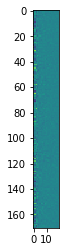

(171, 20)

In [ ]:
plt.imshow(imgs_features, interpolation='none')
plt.show()
imgs_features.shape

In [ ]:
# Preparation
k_labels = kmeans.labels_  # Get cluster labels
k_labels_matched = np.empty_like(k_labels)

# For each cluster label,find and assign the best-matching truth label
for k in np.unique(k_labels):
    match_nums = [np.sum((k_labels==k)*(truth==t)) for t in np.unique(truth)]

    k_labels_matched[k_labels==k] = np.unique(truth)[np.argmax(match_nums)]

[12, 82]
[73, 4]


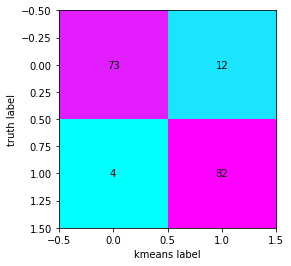

In [ ]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth, k_labels_matched)

# Plot confusion matrix
plt.imshow(cm,interpolation='none',cmap='cool')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("kmeans label")
plt.ylabel("truth label")
plt.show()

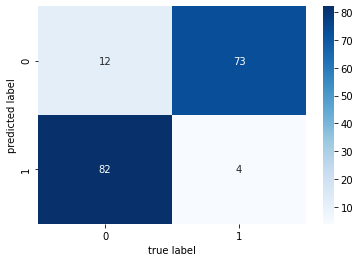

In [ ]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth, k_labels)
# Plot confusion matrix
import seaborn as sns
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
from sklearn.utils.linear_assignment_ import linear_assignment
import numpy as np

def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

indexes = linear_assignment(_make_cost_m(cm))
js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
cm2 = cm[:, js]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


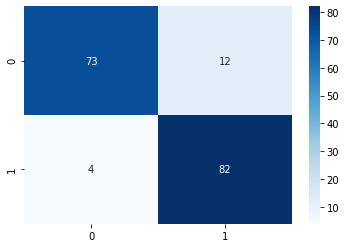

In [ ]:
ax = sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues")

In [ ]:
!pip install coclust

  Created wheel for coclust: filename=coclust-0.2.1-cp36-none-any.whl size=29873 sha256=ad28e1cdade57d0cfb2ebbafbfafcd68a16a7dad01523a07afa83363cfea72ca
  Stored in directory: /root/.cache/pip/wheels/cd/d7/68/df601d0b5f8b934cf890dc626c2271df381fb0c3e910b0a34e
Successfully built coclust


In [ ]:
print(np.trace(cm2) / np.sum(cm2))
from coclust.evaluation.external import accuracy

print(accuracy(truth, k_labels))
from sklearn.metrics.classification import accuracy_score

print(accuracy_score(truth, k_labels))
print(np.trace(cm) / np.sum(cm))

0.9064327485380117
0.9064327485380117
0.0935672514619883
0.0935672514619883


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


# Extra
Delete
Test
Save

In [ ]:
#Delete model
tf.keras.backend.clear_session()

In [ ]:
#To test classifier accuracy
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a yes")
  else:
    print(fn + " is a no")

In [ ]:
model.save('my_model.h5') 
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

In [ ]:
!pip list

Package                       Version        
----------------------------- ---------------
absl-py                       0.10.0         
alabaster                     0.7.12         
albumentations                0.1.12         
altair                        4.1.0          
argon2-cffi                   20.1.0         
asgiref                       3.3.0          
astor                         0.8.1          
astropy                       4.1            
astunparse                    1.6.3          
async-generator               1.10           
atari-py                      0.2.6          
atomicwrites                  1.4.0          
attrs                         20.2.0         
audioread                     2.1.9          
autograd                      1.3            
Babel                         2.8.0          
backcall                      0.2.0          
beautifulsoup4                4.6.3          
bleach                        3.2.1          
blis                          0.4.